
Processing WETH:
Number of borrows: 206
Average borrow amount: 5.68 WETH
Average price: $3015.64


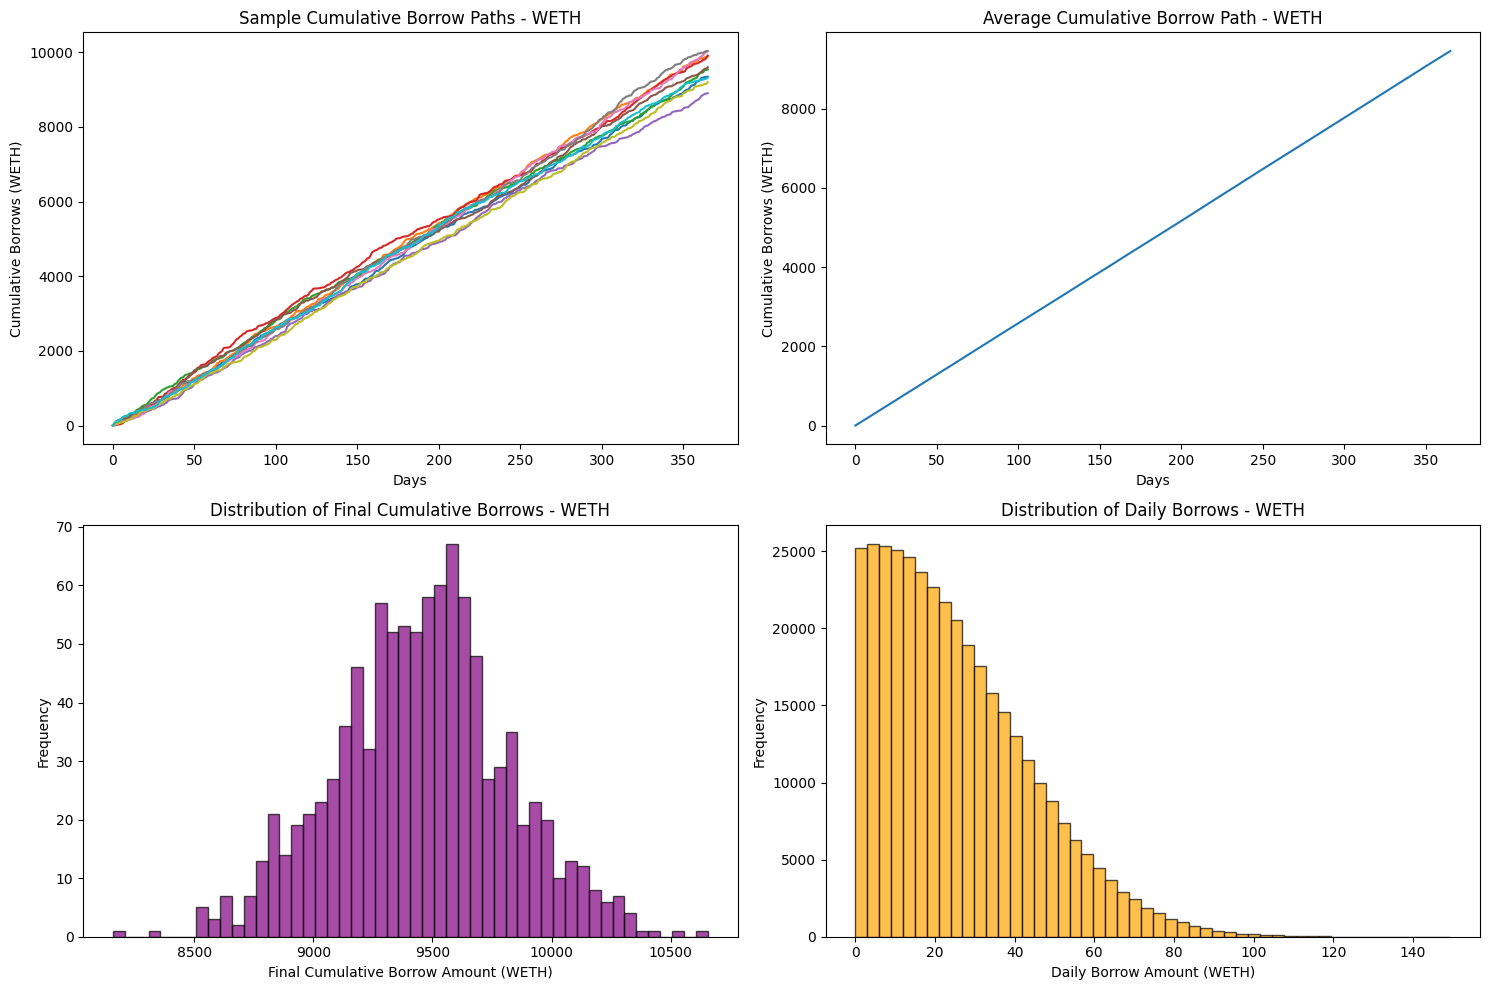

Mean final cumulative borrow: 9452.27 WETH
Median final cumulative borrow: 9464.19 WETH
5th percentile final cumulative borrow: 8827.06 WETH
95th percentile final cumulative borrow: 10066.11 WETH

USD Values (based on average price of $3015.64):
Mean final cumulative borrow: $28504609.80
Median final cumulative borrow: $28540577.80
5th percentile final cumulative borrow: $26619229.47
95th percentile final cumulative borrow: $30355737.47

Processing USDC:
Number of borrows: 641
Average borrow amount: 12138.61 USDC
Average price: $1.00


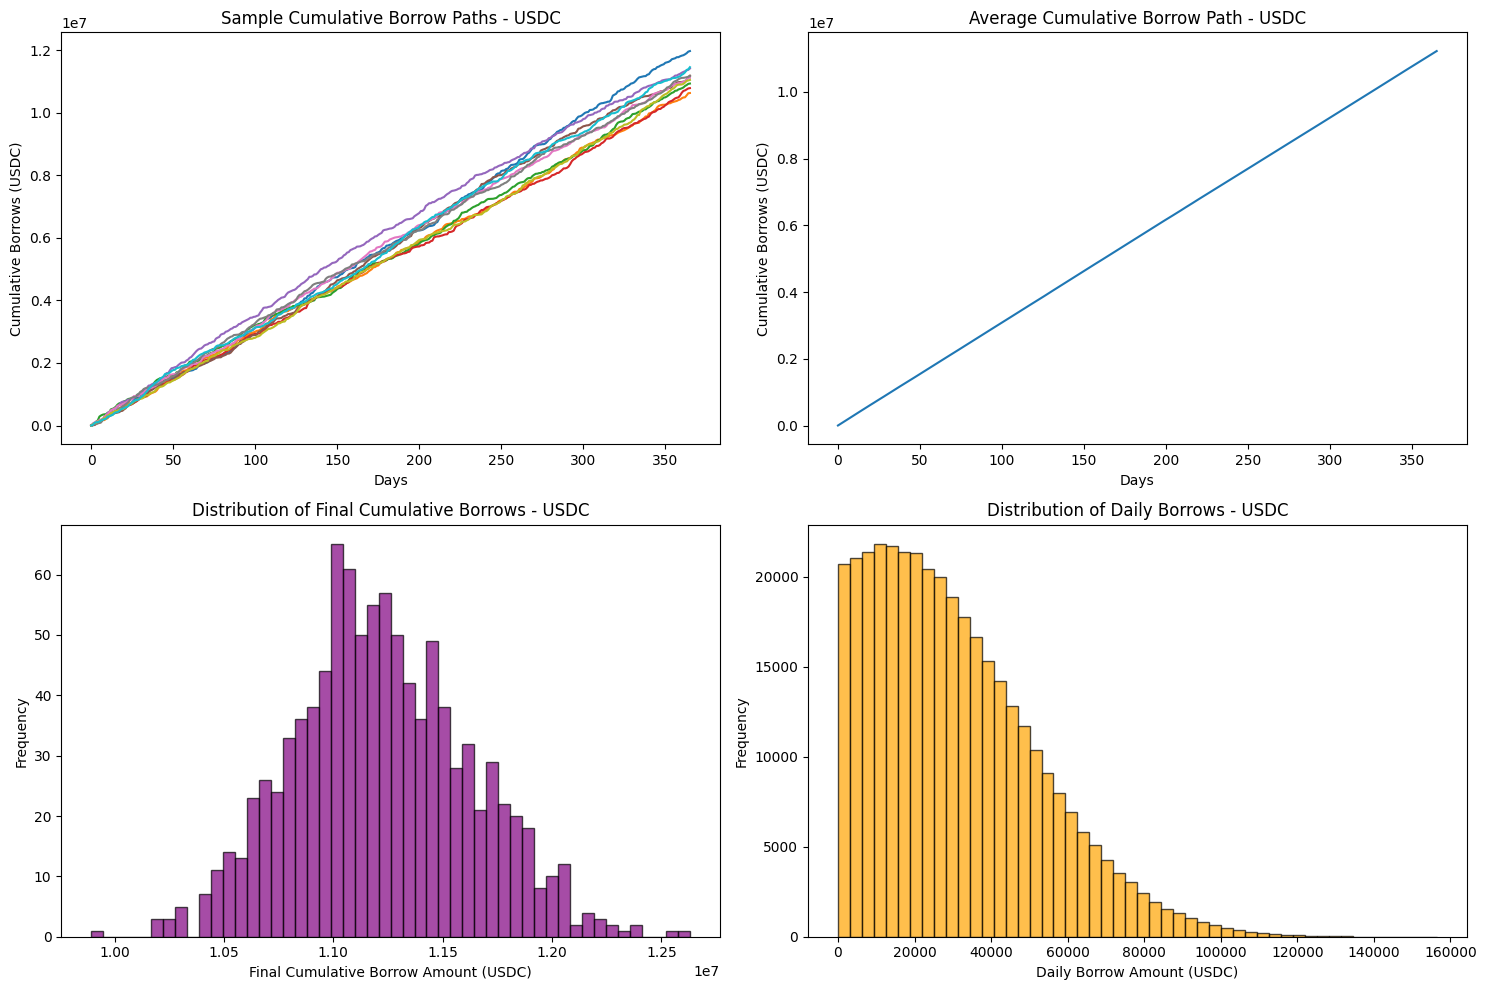

Mean final cumulative borrow: 11219679.26 USDC
Median final cumulative borrow: 11192905.18 USDC
5th percentile final cumulative borrow: 10571316.93 USDC
95th percentile final cumulative borrow: 11906145.50 USDC

USD Values (based on average price of $1.00):
Mean final cumulative borrow: $11219269.23
Median final cumulative borrow: $11192496.13
5th percentile final cumulative borrow: $10570930.60
95th percentile final cumulative borrow: $11905710.38

Processing USDT:
Number of borrows: 163
Average borrow amount: 5129.94 USDT
Average price: $1.00


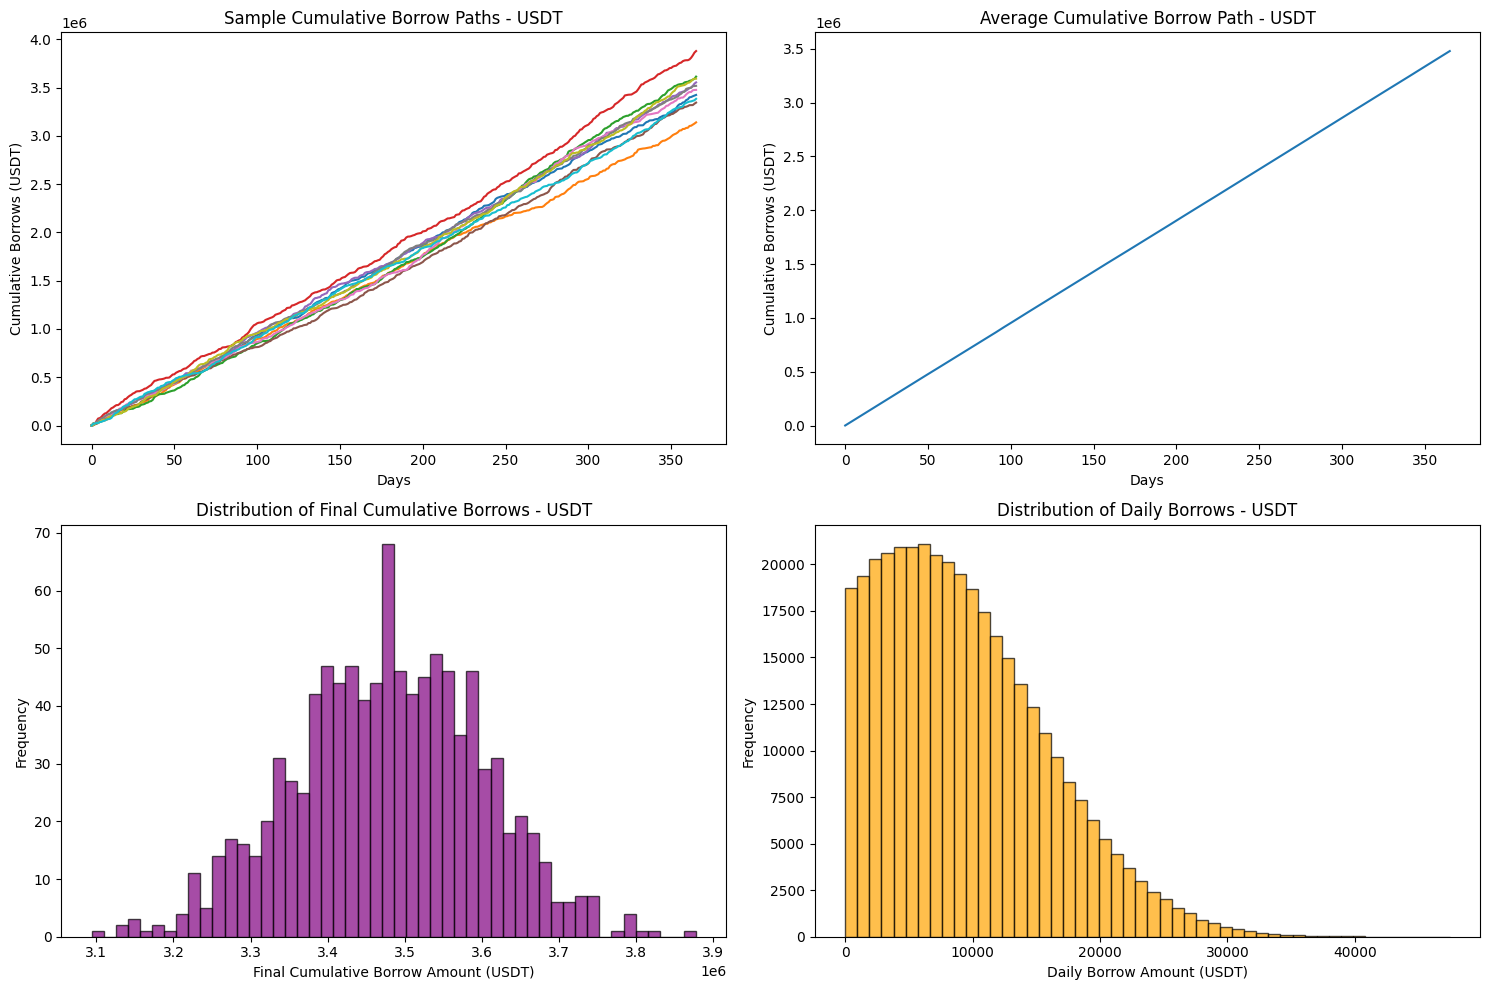

Mean final cumulative borrow: 3478181.93 USDT
Median final cumulative borrow: 3481552.56 USDT
5th percentile final cumulative borrow: 3271831.81 USDT
95th percentile final cumulative borrow: 3669712.49 USDT

USD Values (based on average price of $1.00):
Mean final cumulative borrow: $3479516.75
Median final cumulative borrow: $3482888.67
5th percentile final cumulative borrow: $3273087.44
95th percentile final cumulative borrow: $3671120.81

Processing DAI:
Number of borrows: 251
Average borrow amount: 14345.73 DAI
Average price: $1.00


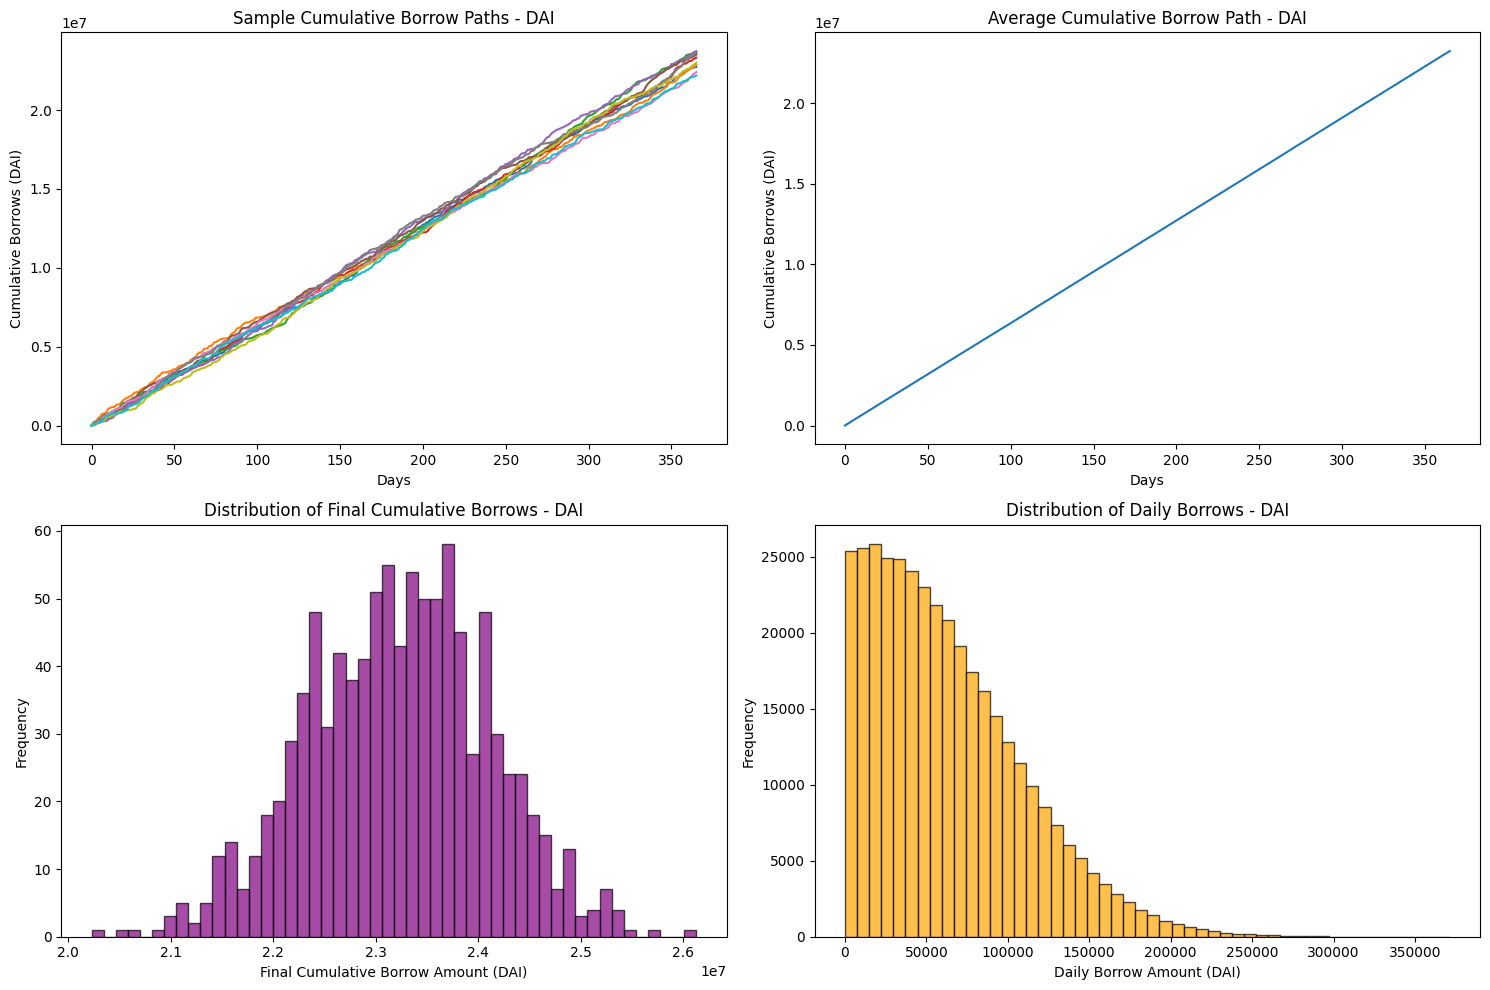

Mean final cumulative borrow: 23227326.24 DAI
Median final cumulative borrow: 23252392.42 DAI
5th percentile final cumulative borrow: 21731868.55 DAI
95th percentile final cumulative borrow: 24613176.14 DAI

USD Values (based on average price of $1.00):
Mean final cumulative borrow: $23233338.93
Median final cumulative borrow: $23258411.60
5th percentile final cumulative borrow: $21737494.12
95th percentile final cumulative borrow: $24619547.58

Processing WBTC:
Number of borrows: 44
Average borrow amount: 0.49 WBTC
Average price: $41540.81


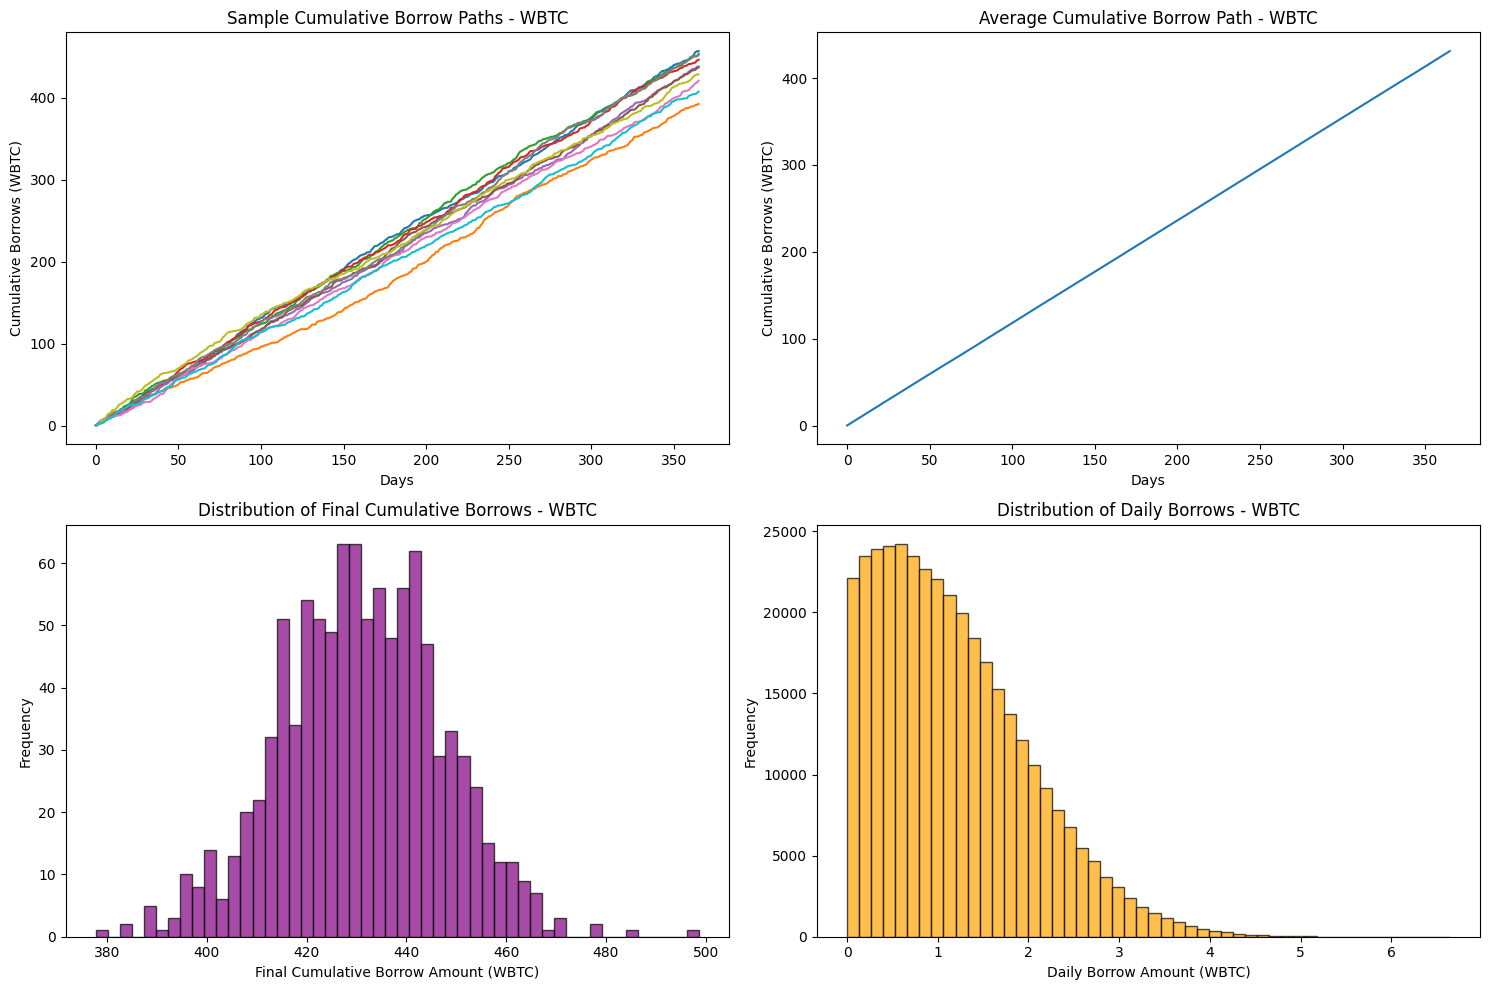

Mean final cumulative borrow: 431.02 WBTC
Median final cumulative borrow: 430.86 WBTC
5th percentile final cumulative borrow: 404.44 WBTC
95th percentile final cumulative borrow: 457.24 WBTC

USD Values (based on average price of $41540.81):
Mean final cumulative borrow: $17905115.57
Median final cumulative borrow: $17898392.82
5th percentile final cumulative borrow: $16800894.27
95th percentile final cumulative borrow: $18993972.43

Processing LINK:
Number of borrows: 23
Average borrow amount: 576.88 LINK
Average price: $14.89


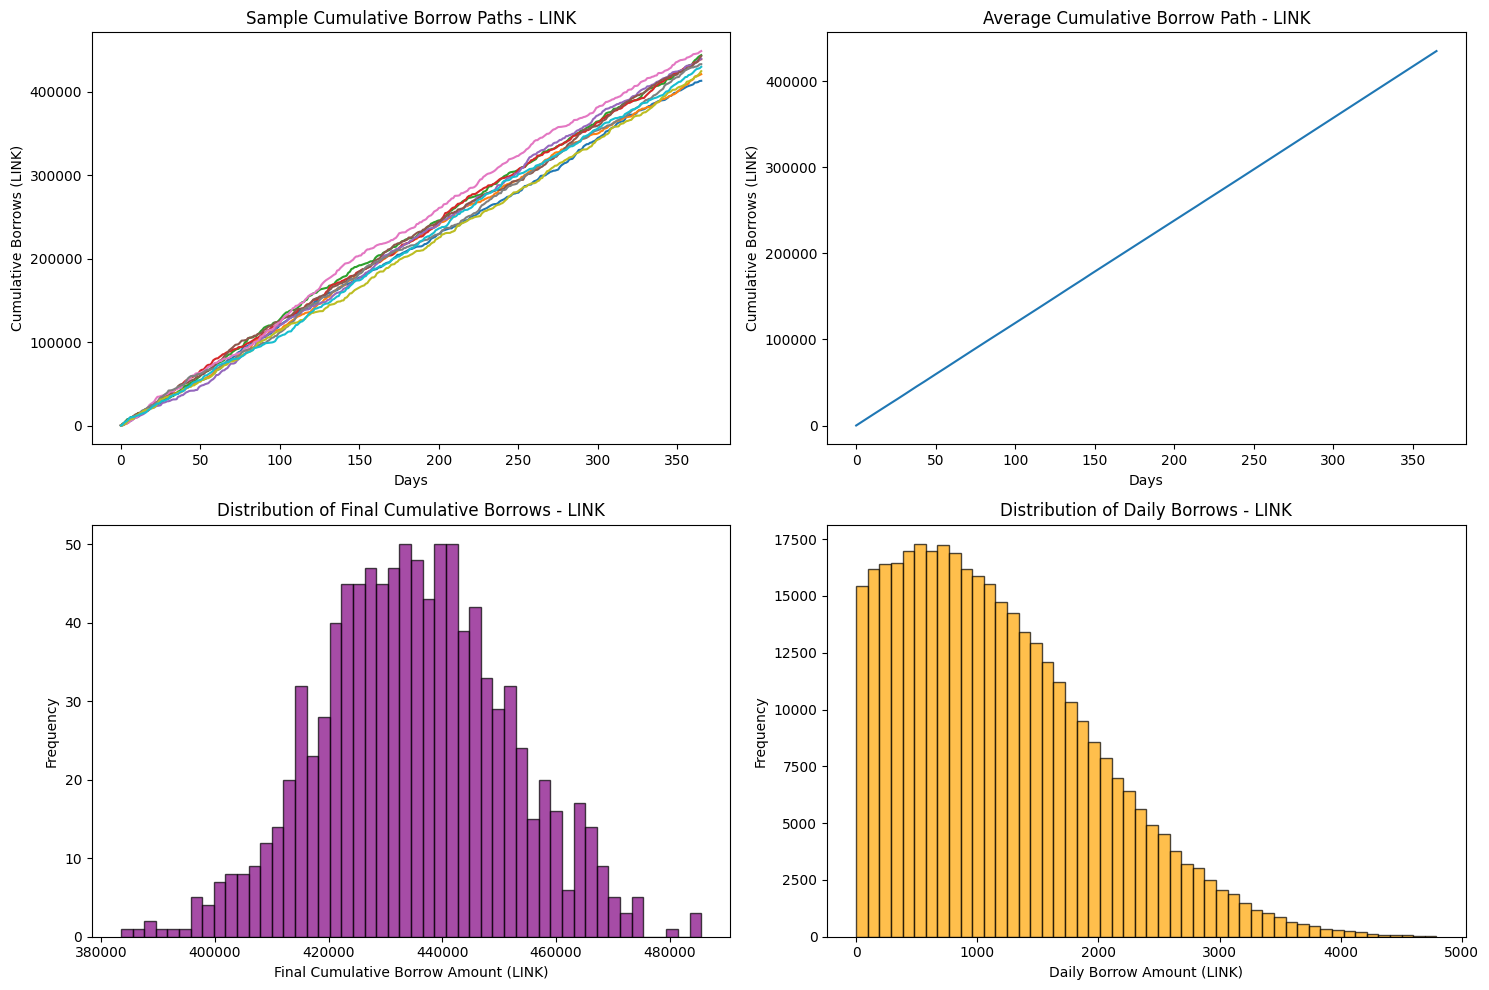

Mean final cumulative borrow: 434944.01 LINK
Median final cumulative borrow: 434654.11 LINK
5th percentile final cumulative borrow: 408138.54 LINK
95th percentile final cumulative borrow: 463914.21 LINK

USD Values (based on average price of $14.89):
Mean final cumulative borrow: $6476854.79
Median final cumulative borrow: $6472537.81
5th percentile final cumulative borrow: $6077688.11
95th percentile final cumulative borrow: $6908256.84

Processing EURS:
Number of borrows: 2
Average borrow amount: 3.67 EURS
Average price: $1.09


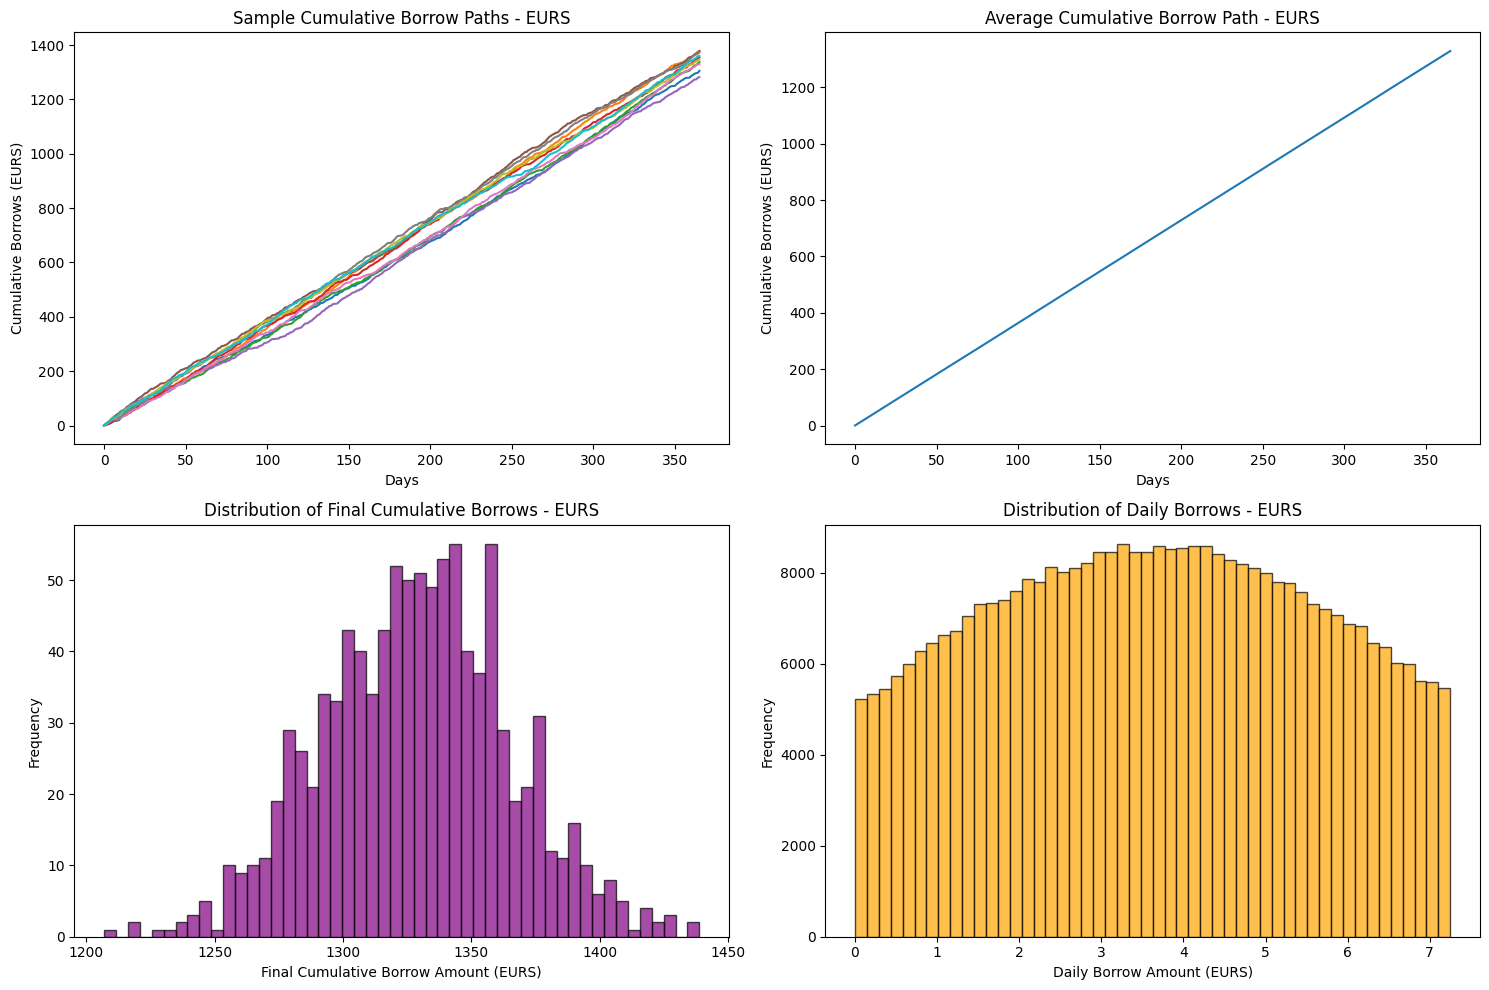

Mean final cumulative borrow: 1328.64 EURS
Median final cumulative borrow: 1329.28 EURS
5th percentile final cumulative borrow: 1269.39 EURS
95th percentile final cumulative borrow: 1390.37 EURS

USD Values (based on average price of $1.09):
Mean final cumulative borrow: $1452.40
Median final cumulative borrow: $1453.09
5th percentile final cumulative borrow: $1387.62
95th percentile final cumulative borrow: $1519.87


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import stats

# Read the Borrow CSV file
borrow_df = pd.read_csv('ARBITRUMBorrow.csv')

# Function to parse the JSON-like string
def parse_json(json_str):
    try:
        data = json.loads(json_str)
        return data.get('symbol', ''), data.get('decimals', 18)
    except:
        return '', 18

# Apply the function to create 'symbol' and 'decimals' columns
borrow_df[['symbol', 'decimals']] = borrow_df.iloc[:, 7].apply(parse_json).tolist()

# Get unique tokens
unique_tokens = borrow_df['symbol'].unique()

def monte_carlo_simulation(borrows, num_simulations, time_horizon):
    mean_borrow = np.mean(borrows)
    std_borrow = np.std(borrows)
    max_borrow = np.max(borrows)

    all_paths = []

    for _ in range(num_simulations):
        cumulative_borrows = [0]  # Start with 0 borrows

        for _ in range(time_horizon):
            if std_borrow > 1e-8:
                daily_borrow = max(stats.truncnorm(
                    (0 - mean_borrow) / std_borrow, 
                    (max_borrow - mean_borrow) / std_borrow,
                    loc=mean_borrow, 
                    scale=std_borrow
                ).rvs(), 0)
            else:
                daily_borrow = mean_borrow

            cumulative_borrows.append(cumulative_borrows[-1] + daily_borrow)

        all_paths.append(cumulative_borrows)

    return all_paths

for token in unique_tokens:
    token_data = borrow_df[(borrow_df['symbol'] == token) & (borrow_df.iloc[:, 1] == 'Borrow')]
    
    if token_data.empty:
        print(f"No borrow data for {token}. Skipping...")
        continue

    decimals = token_data['decimals'].iloc[0]
    borrows = token_data.iloc[:, 2].astype(float).values / (10**decimals)
    prices = token_data.iloc[:, 3].astype(float).values

    print(f"\nProcessing {token}:")
    print(f"Number of borrows: {len(borrows)}")
    print(f"Average borrow amount: {np.mean(borrows):.2f} {token}")
    print(f"Average price: ${np.mean(prices):.2f}")

    num_simulations = 1000
    time_horizon = 365  # 1 year

    if len(borrows) < 2 or np.std(borrows) < 1e-8:
        print(f"Not enough variation in borrows for {token}. Skipping Monte Carlo simulation.")
        continue

    all_paths = monte_carlo_simulation(borrows, num_simulations, time_horizon)

    plt.figure(figsize=(15, 10))

    # Plot some sample paths
    plt.subplot(2, 2, 1)
    for i in range(min(10, num_simulations)):
        plt.plot(all_paths[i])
    plt.title(f"Sample Cumulative Borrow Paths - {token}")
    plt.xlabel("Days")
    plt.ylabel(f"Cumulative Borrows ({token})")

    # Plot average path
    plt.subplot(2, 2, 2)
    avg_path = np.mean(all_paths, axis=0)
    plt.plot(avg_path)
    plt.title(f"Average Cumulative Borrow Path - {token}")
    plt.xlabel("Days")
    plt.ylabel(f"Cumulative Borrows ({token})")

    # Plot distribution of final cumulative borrows
    plt.subplot(2, 2, 3)
    final_borrows = [path[-1] for path in all_paths]
    plt.hist(final_borrows, bins=50, color='purple', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Final Cumulative Borrows - {token}")
    plt.xlabel(f"Final Cumulative Borrow Amount ({token})")
    plt.ylabel("Frequency")

    # Plot distribution of daily borrows
    plt.subplot(2, 2, 4)
    daily_borrows = [path[i+1] - path[i] for path in all_paths for i in range(len(path)-1)]
    plt.hist(daily_borrows, bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of Daily Borrows - {token}")
    plt.xlabel(f"Daily Borrow Amount ({token})")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    print(f"Mean final cumulative borrow: {np.mean(final_borrows):.2f} {token}")
    print(f"Median final cumulative borrow: {np.median(final_borrows):.2f} {token}")
    print(f"5th percentile final cumulative borrow: {np.percentile(final_borrows, 5):.2f} {token}")
    print(f"95th percentile final cumulative borrow: {np.percentile(final_borrows, 95):.2f} {token}")

    avg_price = np.mean(prices)
    print(f"\nUSD Values (based on average price of ${avg_price:.2f}):")
    print(f"Mean final cumulative borrow: ${np.mean(final_borrows) * avg_price:.2f}")
    print(f"Median final cumulative borrow: ${np.median(final_borrows) * avg_price:.2f}")
    print(f"5th percentile final cumulative borrow: ${np.percentile(final_borrows, 5) * avg_price:.2f}")
    print(f"95th percentile final cumulative borrow: ${np.percentile(final_borrows, 95) * avg_price:.2f}")